# Home Work №1
Вам предстоит поработать с данными, описывающими биомеханические особенности ортопедических больных. Везде, где требуется написать свой код или ответ, помечено %%

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [ ]:
# Оставим вывод только двух чисел после запятой
pd.set_option('precision', 2)

## Шаг 1: Знакомство с таблицей

In [ ]:
# Загрузим данные из файла column_2C_weka.csv
data = pd.read_csv("column_2C_weka.csv")

In [ ]:
# Какой размер таблицы?
print(data.shape)

(225, 8)


In [ ]:
# Какие есть признаки в таблице? 
print(data.columns)

Index(['pelvic_incidence', 'pelvic_tilt numeric', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis',
       'jump_height', 'class'],
      dtype='object')


In [ ]:
# Посмотрим первые несколько строк таблицы
data.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,jump_height,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,34.56,Abnormal
1,49.71,9.65,28.32,40.06,108.17,7.92,10.03,Abnormal
2,NaN,13.92,25.12,26.33,130.33,2.23,NaN,Abnormal
3,53.43,15.86,37.17,37.57,120.57,5.99,31.68,Abnormal
4,44.32,12.54,36.10,31.78,124.12,5.42,NaN,Abnormal


In [ ]:
#Индивидуальный набор samplов размера 200, над которым будет проводиться дальнейшая работа
sample = data.sample(n=200)

## Шаг 2: Изучение на наличие нулевых значений

In [ ]:
#Посмотрим на содержание данных относительно ненулевых значений
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          222 non-null    float64
 1   pelvic_tilt numeric       222 non-null    float64
 2   lumbar_lordosis_angle     223 non-null    float64
 3   sacral_slope              222 non-null    float64
 4   pelvic_radius             222 non-null    float64
 5   degree_spondylolisthesis  222 non-null    float64
 6   jump_height               19 non-null     float64
 7   class                     225 non-null    object 
dtypes: float64(7), object(1)
memory usage: 14.2+ KB


In [ ]:
# Какой столбец сильно выделяется?
# Ответ: 6:jump_height

In [ ]:
#Посмотрим на первые несколько строк, где этот столбец is null
data['jump_height'][data['jump_height'].isnull()].head()

2   NaN
4   NaN
5   NaN
6   NaN
7   NaN
Name: jump_height, dtype: float64

In [ ]:
# Является ли он информативным? 
# Ответ: no

In [ ]:
# Если нет, то удалите его
data2 = data.drop(labels = ['jump_height'], axis=1)  #### axis??

In [ ]:
# Посмотрим на какой-нибудь еще один столбец, где есть нулевые значения
data['pelvic_incidence']

0      63.03
1      49.71
2        NaN
3      53.43
4      44.32
       ...  
220    47.90
221    53.94
222    61.45
223    45.25
224    33.84
Name: pelvic_incidence, Length: 225, dtype: float64

In [ ]:
# Имеет ли смысл удалять всю стороку, где есть хотя бы один NaN, при условии, что данных мало?
# Ответ: No

In [ ]:
# Если нет, то что можно сделать еще? Учитывая, что признаки являются количественными, что подойдет лучше всего?
# Ответ: to apply K-nearest neighbor model  
# A new sample is imputed by finding the samples in the training set “closest” to it and
# averages these nearby points to fill in the value. 
# or to replace NA with column mean

In [ ]:
# Сделайте выбранное преобразование. Используйте fillna с переданным значение value = sample.mean()
sample = data2
value = sample['pelvic_incidence'].fillna(sample['pelvic_incidence'].mean())

In [ ]:
# Посмотрим на содержание данных относительно ненулевых значений теперь
value.head()

0    63.03
1    49.71
2    60.51
3    53.43
4    44.32
Name: pelvic_incidence, dtype: float64

## Шаг 3: сбалансированность классов

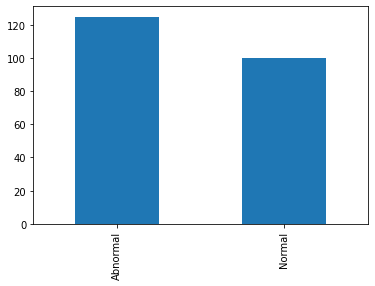

In [ ]:
# Исследуем сбалансированность классов.
sample['class'].value_counts().plot(kind='bar')

In [ ]:
# Все в порядке? 
# Ответ: Yes, classes are more or less balanced 

## Шаг 4: Выбросы

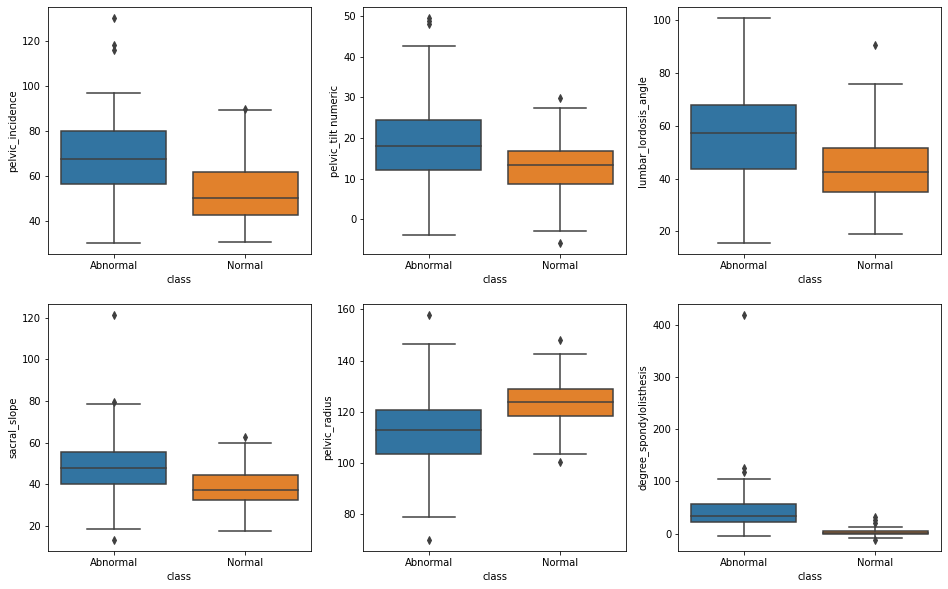

In [ ]:
# Исследуем данные на выбросы.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

for idx, feat in  enumerate(sample.columns[:6]):
    sns.boxplot(x='class', y=feat, data=sample, ax=axes[int(idx / 3), idx % 3])
    axes[int(idx / 3), idx % 3].set_xlabel('class')
    axes[int(idx / 3), idx % 3].set_ylabel(feat);

In [ ]:
# Имееются ли выбросы?
# Ответ: yes, there are outliers, they are showen as dots 

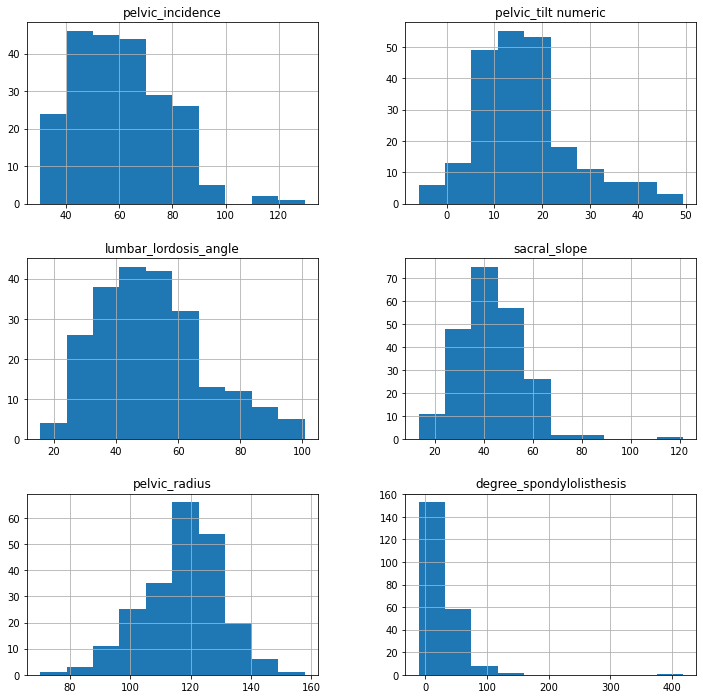

In [ ]:
# Посмотрим на смещение данных. 
sample[sample.columns[:6]].hist(figsize=(12,12));

In [ ]:
# Какие признаки имеют смещение? Согласуются ли boxplot и histogram для признаков между собой?
# Ответ: pelvic_incidence, pelvic_tilt numeric (?), lumbar_lordosis_angle, degree_spondylolisthesis, sacral_slope (?) - 
# graphs are left skrewed
# Boxplots and histograms are in good agreement mean and data spread wise. 

In [ ]:
# Удалим выбросы, выступающие за границы 3 сигма
low = 0.01
high = 0.99
quant_data = sample.quantile([low, high])
for name in list(sample.drop(labels=['class'], axis=1).columns):
    sample = sample[(sample[name] > quant_data.loc[low, name]) & (sample[name] < quant_data.loc[high, name])]

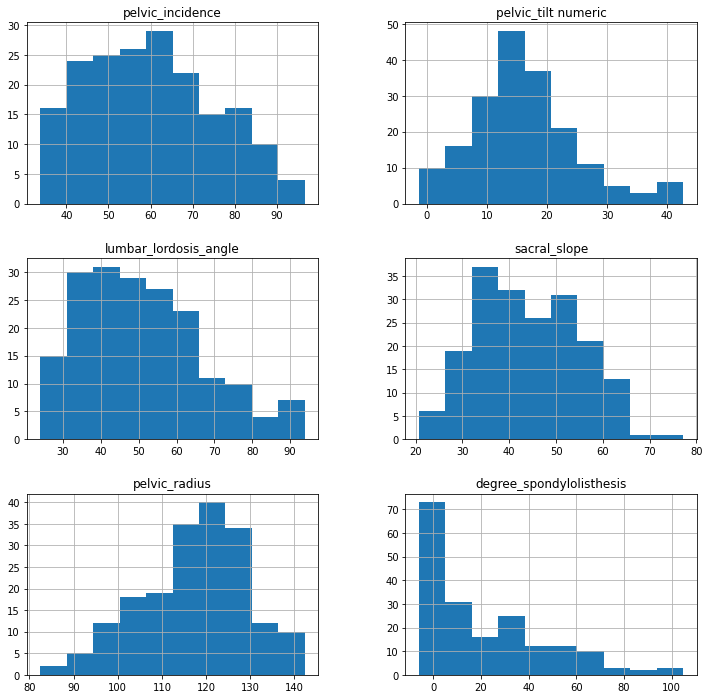

In [ ]:
# Посмотрим на смещение данных теперь
sample[sample.columns[:6]].hist(figsize=(12,12));

## Шаг 5: Scale

In [ ]:
# Разделим таблицу на X и Y
X = sample.drop(labels=['class'], axis=1)
Y = sample['class']
# и на train и test  отношении 80/20 процентов
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state = 42)

In [ ]:
Y

0      Abnormal
1      Abnormal
3      Abnormal
4      Abnormal
5      Abnormal
         ...   
220      Normal
221      Normal
222      Normal
223      Normal
224      Normal
Name: class, Length: 187, dtype: object

In [ ]:
X

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
0,63.03,22.55,39.61,40.48,98.67,-0.25
1,49.71,9.65,28.32,40.06,108.17,7.92
3,53.43,15.86,37.17,37.57,120.57,5.99
4,44.32,12.54,36.10,31.78,124.12,5.42
5,63.83,20.36,54.55,43.47,112.31,-0.62
...,...,...,...,...,...,...
220,47.90,13.62,36.00,34.29,117.45,-4.25
221,53.94,20.72,29.22,33.22,114.37,-0.42
222,61.45,22.69,46.17,38.75,125.67,-2.71
223,45.25,8.69,41.58,36.56,118.55,0.21


In [ ]:
# Проведем scaling данных
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_array = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_array, index=X_train.index, columns=X_train.columns)

X_test_array = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_array, index=X_test.index, columns=X_test.columns)

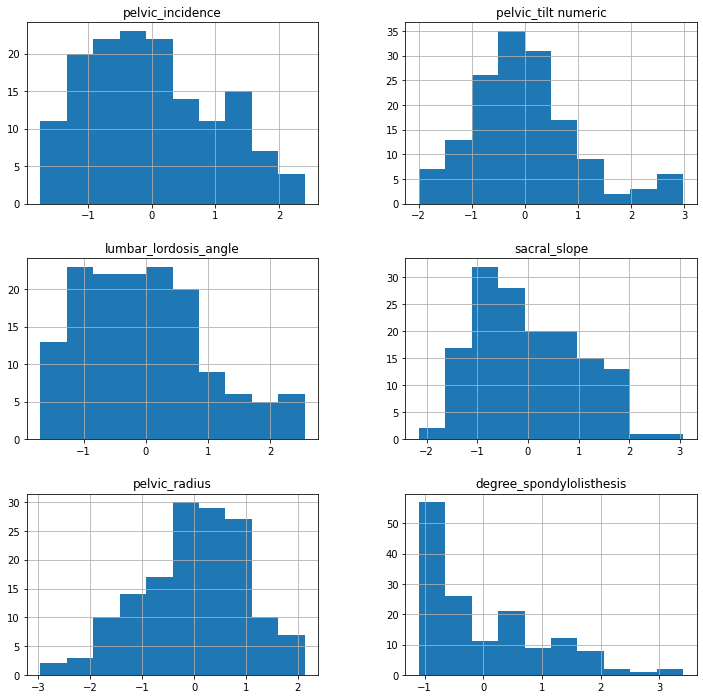

In [ ]:
# Посмотрим на гистограммы признаков
X_train[X_train.columns[:6]].hist(figsize=(12,12));

In [ ]:
# Что изменилось?
# Ответ: data became normalized

## Шаг 6: PCA

In [ ]:
# Создайте класс PCA для шести компонент и обучите на X_train
pca = PCA(n_components=6) 
pca.fit(X_train)  

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# Проведите трансформацию PCA
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

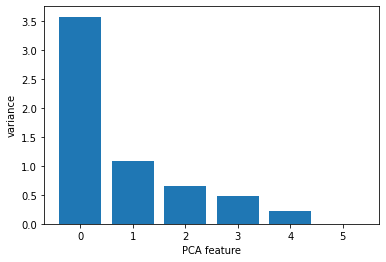

In [ ]:
# Построим bar plot
plt.bar(range(pca.n_components_), pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.show()



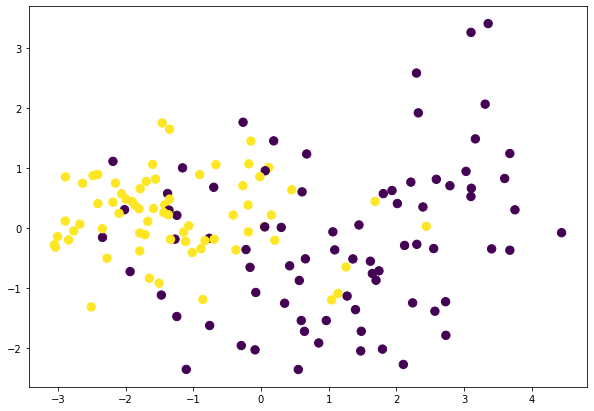

In [ ]:
# Переведем Y_train в числовые значения
d = dict(zip(set(Y_train), [0,1]))
label = list()
for i in Y_train:
    label.append(d[i])

# И построим на двух компонентах
plt.figure(figsize=(10,7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=label, s=70, cmap='viridis')
plt.show()

Text(0.5, 1.0, '1 vs 3')

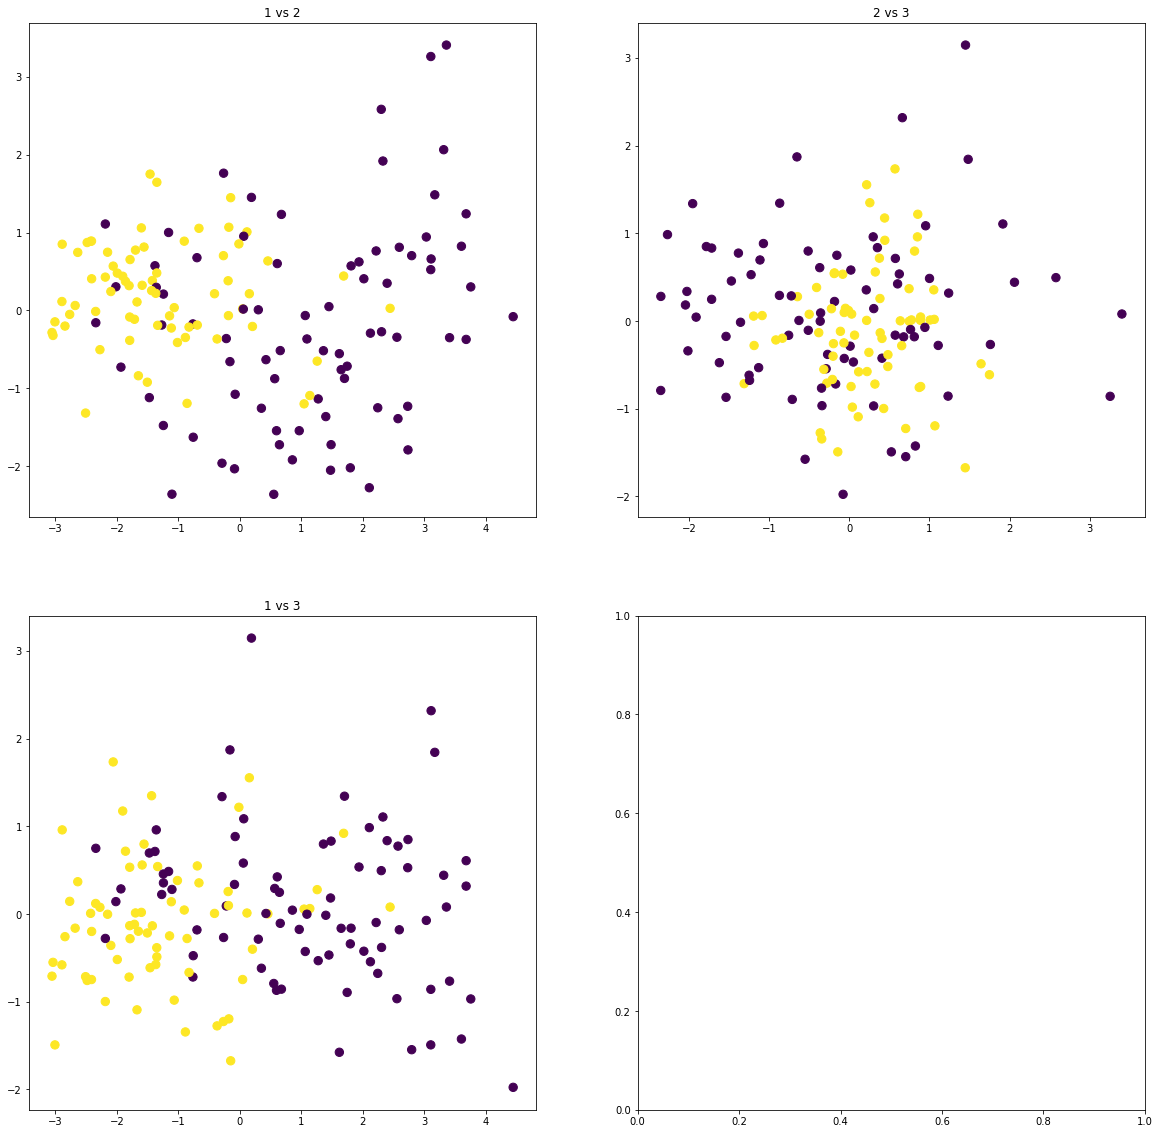

In [ ]:
# Постойте попарно 1-2, 2-3, 1-3 компоненты

fig, ax=plt.subplots(nrows=2, ncols=2, figsize=(20,20))

# fig.suptitle('')
ax[0,0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=label, s=70, cmap='viridis')
ax[0,0].set_title('1 vs 2')

ax[0,1].scatter(X_train_pca[:, 1], X_train_pca[:, 2], c=label, s=70, cmap='viridis')
ax[0,1].set_title('2 vs 3')

ax[1,0].scatter(X_train_pca[:, 0], X_train_pca[:, 2], c=label, s=70, cmap='viridis')
ax[1,0].set_title('1 vs 3')

In [ ]:
# Выведите, сколько компонент объясняют >95% variance
for i in range(6):
    print( str(i) + ' parameters managed to capture: ' + 
    str(sum(pca.explained_variance_ratio_[:i]))[:5] + ' of explained variance')

0 parameters managed to capture: 0 of explained variance
1 parameters managed to capture: 0.593 of explained variance
2 parameters managed to capture: 0.773 of explained variance
3 parameters managed to capture: 0.882 of explained variance
4 parameters managed to capture: 0.962 of explained variance
5 parameters managed to capture: 0.999 of explained variance
